In [38]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
DATA_PATH = "data"
TRAIN_PATH = '%s/train/' % (DATA_PATH)
VALID_PATH = '%s/valid/' % (DATA_PATH)
TEST_PATH = '%s/test/' % (DATA_PATH)

In [15]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [16]:
vgg_model = Sequential()
vgg_model.add(conv_base)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dense(1, activation='sigmoid'))

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [18]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [19]:
conv_base.trainable = False

In [20]:
train_datagen = ImageDataGenerator(rescale=1.0/255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,target_size=image_size,batch_size=batch_size,class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VALID_PATH,target_size=image_size,batch_size=batch_size,class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [24]:
vgg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model = ModelCheckpoint("./vgg16/hydpressure_vgg16.h5", monitor='val_loss', verbose=0, save_best_only=True)

history = vgg_model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            validation_steps=8,
            epochs=10,
            validation_data=validation_generator,
            callbacks=[best_model, TensorBoard(log_dir='./vgg16/logs')])

Epoch 1/10
100/100 [==============================] - 633s 6s/step - loss: 0.2901 - acc: 0.8895 - val_loss: 0.1679 - val_acc: 0.9350
Epoch 2/10
100/100 [==============================] - 674s 7s/step - loss: 0.1350 - acc: 0.9480 - val_loss: 0.0992 - val_acc: 0.9650
Epoch 3/10
100/100 [==============================] - 700s 7s/step - loss: 0.1195 - acc: 0.9515 - val_loss: 0.0734 - val_acc: 0.9650
Epoch 4/10
100/100 [==============================] - 627s 6s/step - loss: 0.1002 - acc: 0.9635 - val_loss: 0.0776 - val_acc: 0.9700
Epoch 5/10
100/100 [==============================] - 654s 7s/step - loss: 0.1186 - acc: 0.9600 - val_loss: 0.0900 - val_acc: 0.9650
Epoch 6/10
100/100 [==============================] - 662s 7s/step - loss: 0.1205 - acc: 0.9565 - val_loss: 0.0776 - val_acc: 0.9700
Epoch 7/10
100/100 [==============================] - 645s 6s/step - loss: 0.1062 - acc: 0.9635 - val_loss: 0.0834 - val_acc: 0.9700
Epoch 8/10
100/100 [==============================] - 650s 7s/step - 

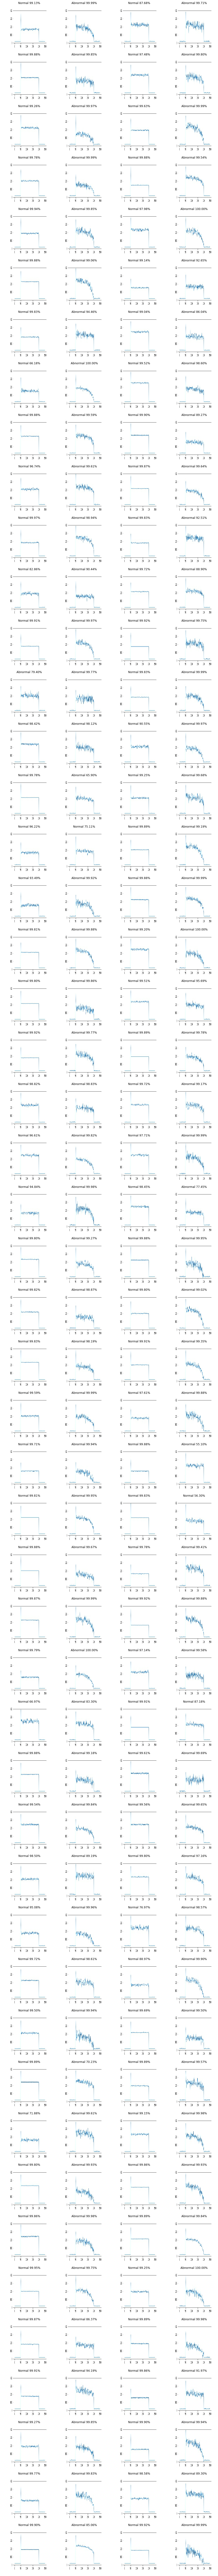

In [125]:
import os
test_images  = os.listdir(TEST_PATH)
x = zip([int(re.findall('\d+', i)[0]) for i in test_images], test_images)
test_images = [i for i in x]
test_images.sort(key=itemgetter(0))
test_images = [i[1] for i in test_images]

from keras.preprocessing.image import load_img, img_to_array

def preprocess_image(img_path):
    img = load_img(img_path, target_size=image_size)
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor

result = []

plt.figure(figsize=(16, 200))
for index, image in enumerate(test_images):
    img = preprocess_image(TEST_PATH + image)
    
    prediction = vgg_model.predict(img)[0]
    
    plt.subplot(50, 4, index+1)
    if prediction < 0.5:
        plt.title('Abnormal %.2f%%' % (100 - prediction*100))
        result.append('Abnormal')
    else:
        plt.title('Normal %.2f%%' % (prediction*100))
        result.append('Normal')
    
    plt.axis('off')
    plt.imshow(img[0])